Segmentation of Indian Traffic

In [1]:
import warnings
warnings.filterwarnings('ignore')

1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

<pre>
|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

In [2]:
! pip install patool --quiet

     |████████████████████████████████| 77 kB 6.8 MB/s 


In [3]:
! pip install --upgrade --no-cache-dir gdown --quiet

In [4]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use(style='seaborn-deep')

In [5]:
from PIL import Image, ImageDraw
from PIL import ImagePath

In [6]:
from tqdm import tqdm

In [7]:
import cv2 as cv
import json
import math
import more_itertools
import numpy as np
import os
import pandas as pd
import patoolib
import time
import urllib

In [9]:
# !gdown --id 1amlgtB803DlMyLDHSJjXs_j4AjMGB_Xi

In [11]:
# patoolib.extract_archive(archive='/content/data_polygons_output.zip', outdir='/content/data')

Task 1: Preprocessing

Task 1.1 Get all the file name and corresponding json files

In [12]:
root_dir = "/content/data"

In [13]:
def return_file_names_df(root_dir):
    """
    Returns the file names.
    """
    images_dir = os.path.join(root_dir, 'images')
    mask_dir = os.path.join(root_dir, 'mask')
    images_scenes = sorted(os.listdir(path=images_dir))
    mask_scenes = sorted(os.listdir(path=mask_dir))

    image_files = []
    json_files = []
    for i_scene, m_scene in tqdm(list(zip(images_scenes, mask_scenes))):
        i_scene_path = os.path.join(images_dir, i_scene)
        m_scene_path = os.path.join(mask_dir, m_scene)
        images_frames = sorted(os.listdir(path=i_scene_path))
        mask_frames = sorted(os.listdir(path=m_scene_path))

        for i_frame, m_frame in zip(images_frames, mask_frames):
            image_files.append(os.path.join(i_scene_path, i_frame))
            json_files.append(os.path.join(m_scene_path, m_frame))
    
    data_df = pd.DataFrame()
    data_df['image'] = image_files
    data_df['json'] = json_files
    return data_df

In [14]:
data_df = return_file_names_df(root_dir=root_dir)
data_df.head()

100%|██████████| 143/143 [00:00<00:00, 7105.54it/s]


,image,json
0,/content/data/images/201/frame0029_leftImg8bit...,/content/data/mask/201/frame0029_gtFine_polygo...
1,/content/data/images/201/frame0299_leftImg8bit...,/content/data/mask/201/frame0299_gtFine_polygo...
2,/content/data/images/201/frame0779_leftImg8bit...,/content/data/mask/201/frame0779_gtFine_polygo...
3,/content/data/images/201/frame1019_leftImg8bit...,/content/data/mask/201/frame1019_gtFine_polygo...
4,/content/data/images/201/frame1469_leftImg8bit...,/content/data/mask/201/frame1469_gtFine_polygo...


If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [15]:
def grader_1(data_df):
    for i in data_df.values:
        if not (os.path.isfile(i[0]) and 
                os.path.isfile(i[1]) and 
                i[0][21:i[0].find('_')] == i[1][19:i[1].find('_')]):
            return False
    return True

In [16]:
grader_1(data_df=data_df)

True

In [17]:
data_df.shape

(4008, 2)

Task 1.2 Structure of sample Json file

![](https://i.imgur.com/EfR5KmI.png)

Each File will have 3 attributes
1. imgHeight: which tells the height of the image
2. imgWidth: which tells the width of the image
3. objects: it is a list of objects, each object will have multiple attributes
    - label: the type of the object
    - polygon: a list of two element lists, representing the coordinates of the polygon

Compute the unique labels

Let's see how many unique objects are there in the json file.
To see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>.

<img src='https://i.imgur.com/L4QH6Tp.png'>

Reference: https://more-itertools.readthedocs.io/en/stable/api.html#more_itertools.collapse

In [18]:
def read_json_content_for_label(json_file):
    """
    Reads the JSON file.
    """
    with open(file=json_file, mode='r') as jf:
        data = json.load(jf)
    
    objects = data['objects']
    labels = [obj['label'] for obj in objects]
    return labels

def return_unique_labels(data_df):
    """
    Returns the unique labels.
    """
    json_files = data_df['json'].values
    labels = list(map(read_json_content_for_label, tqdm(json_files)))
    labels = list(more_itertools.collapse(iterable=labels))
    unique_labels = list(set(labels))
    return unique_labels

In [19]:
unique_labels = return_unique_labels(data_df=data_df)

100%|██████████| 4008/4008 [00:19<00:00, 208.05it/s]


In [20]:
label_clr = {'road': 10, 'parking': 20, 'drivable fallback': 20, 'sidewalk': 30, 'non-drivable fallback': 40, 
             'person': 50, 'animal': 50, 'rider': 60, 'motorcycle': 70, 'bicycle': 70, 'autorickshaw': 80, 
             'car': 80, 'truck': 90, 'bus': 90, 'vehicle fallback': 90, 'trailer': 90, 'caravan': 90, 'rail track': 40, 
             'curb': 100, 'wall': 100, 'fence': 110, 'guard rail': 110, 'billboard': 120, 'traffic sign': 120, 
             'traffic light': 120, 'pole': 130, 'polegroup': 130, 'obs-str-bar-fallback': 130, 'building': 140, 
             'bridge': 140, 'tunnel': 140, 'vegetation': 150, 'sky': 160, 'fallback background': 160, 'unlabeled': 0, 
             'out of roi': 0, 'ego vehicle': 170, 'ground': 180, 'rectification border': 190, 'train': 200}

In [21]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys()) - set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

In [22]:
grader_2(unique_labels=unique_labels)

True


* Here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array / 10

Task 1.3 Extracting the polygons from the json files

In [23]:
def get_poly(json_file):
    # This function will take a file name as argument
    
    # It will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # Note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # The other represents the location
    
    # Width of the image
    # Weight of the image

    with open(file=json_file, mode='r') as jf:
        data = json.load(jf)
    
    objects = data['objects']
    width = data['imgWidth']
    height = data['imgHeight']

    labels = []
    vertexlist = []
    for obj in objects:
        labels.append(obj['label'])
        vertexlist.append([tuple(vertex) for vertex in obj['polygon']])
    
    return width, height, labels, vertexlist

In [24]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(json_file=file)
    return ((len(set(labels)) == 18) and 
            (len(vertexlist) == 227) and 
            (w == 1920) and (h == 1080) and 
            isinstance(vertexlist, list) and 
            isinstance(vertexlist[0], list) and 
            isinstance(vertexlist[0][0], tuple))

In [25]:
grader_3(file='/content/data/mask/201/frame0029_gtFine_polygons.json')

True

Task 1.4 Creating Image segmentations by drawing set of polygons

Example

In [26]:
side = 8
x1 = [ ((math.cos(th) + 1) * 9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) * 9, (math.sin(th) + 3) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28, 28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill=20)
# writing the second polygon
img1.polygon(x2, fill=30)

img = np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
print(img.shape)
print(img[:, :, 0] // 10)
im = Image.fromarray(img[:, :, 0])
# im.save("test_image.png")

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

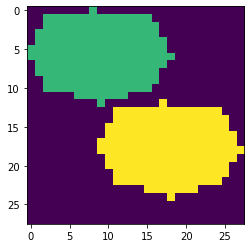

In [27]:
plt.imshow(img[:, :, 0])
plt.show()

In [28]:
def compute_masks(data_df, label_clr=label_clr):
    # After you have computed the vertexlist, plot that polygon in image like this
    
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    # After drawing all the polygons that we collected from json file, 
    # You need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # After saving the image into disk, store the path in a list
    # After storing all the paths, add a column to the data_df['mask'] ex: data_df['mask'] = mask_paths

    mask = []
    for json_file in tqdm(data_df['json'].values):
        w, h, labels, vertexlist = get_poly(json_file=json_file)

        img = Image.new("RGB", (w, h))
        img1 = ImageDraw.Draw(img)

        for i in range(len(labels)):
            if (len(vertexlist[i]) > 1):
                img1.polygon(vertexlist[i], fill=label_clr[labels[i]])
        img = np.array(img)
        im = Image.fromarray(img[:, :, 0])
            
        new_file = json_file.replace('mask', 'output')
        new_file = new_file.replace('json', 'png')
        os.makedirs('/content/data/output/' + json_file.split('/')[4], exist_ok=True)

        im.save(new_file)
        mask.append(new_file)

    data_df['mask'] = mask
    data_df.to_csv(path_or_buf=os.path.join(root_dir, 'preprocessed_data'))
    return data_df

In [29]:
if not os.path.isfile(path=os.path.join(root_dir, 'preprocessed_data')):
    data_df = compute_masks(data_df=data_df)
else:
    print('File already exists.')
    data_df = pd.read_csv(filepath_or_buffer=os.path.join(root_dir, 'preprocessed_data'), index_col=0)

100%|██████████| 4008/4008 [03:42<00:00, 17.98it/s]


In [30]:
data_df.head()

,image,json,mask
0,/content/data/images/201/frame0029_leftImg8bit...,/content/data/mask/201/frame0029_gtFine_polygo...,/content/data/output/201/frame0029_gtFine_poly...
1,/content/data/images/201/frame0299_leftImg8bit...,/content/data/mask/201/frame0299_gtFine_polygo...,/content/data/output/201/frame0299_gtFine_poly...
2,/content/data/images/201/frame0779_leftImg8bit...,/content/data/mask/201/frame0779_gtFine_polygo...,/content/data/output/201/frame0779_gtFine_poly...
3,/content/data/images/201/frame1019_leftImg8bit...,/content/data/mask/201/frame1019_gtFine_polygo...,/content/data/output/201/frame1019_gtFine_poly...
4,/content/data/images/201/frame1469_leftImg8bit...,/content/data/mask/201/frame1469_gtFine_polygo...,/content/data/output/201/frame1469_gtFine_poly...


In [31]:
data_df.head().iloc[0, :]

image    /content/data/images/201/frame0029_leftImg8bit...
json     /content/data/mask/201/frame0029_gtFine_polygo...
mask     /content/data/output/201/frame0029_gtFine_poly...
Name: 0, dtype: object

Task 1.5 Plot the original and masked together

In [32]:
def read_image(file):
    h = 512
    w = 512
    image = cv.imread(file, cv.IMREAD_UNCHANGED)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (w, h), interpolation=cv.INTER_AREA)
    return image

def plot_original_and_masked(original_file, masked_file):
    orig_image = read_image(file=original_file)
    masked_image = read_image(file=masked_file)

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.title('Original')
    plt.imshow(orig_image)

    plt.subplot(1, 2, 2)
    plt.title('Masked')
    plt.imshow(masked_image[:,:,0])

    plt.show()
    return None

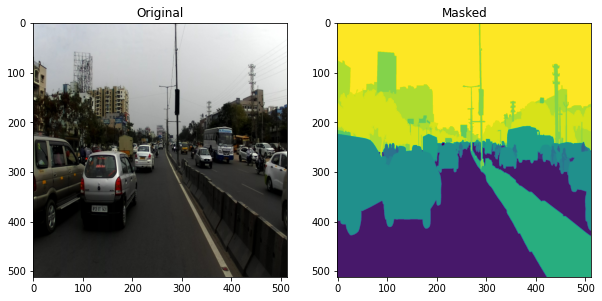

In [33]:
original_file = data_df['image'][400]
masked_file = data_df['mask'][400]

plot_original_and_masked(original_file=original_file, masked_file=masked_file)

Task 2: Applying Unet to segment the images

![](https://i.imgur.com/rD4yP7J.jpg)

* Please check the paper: https://arxiv.org/abs/1505.04597

* As a part of this assignment we won't writing this whole architecture, rather we will be doing transfer learning

* Please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* Please use the loss function that is used in the refence notebooks

Task 2.1: Dice loss

References: 
1. https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b
2. https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient

* Explain the Dice loss

    Dice Loss is a metric used to compute the similarity between two samples (images). This metric is flexible to use even in class imbalanced datasets (which is not same as cross-entropy). It is a performance metric for boundary detection.

* 1. Write the formualtion

    ![](https://i.stack.imgur.com/Usv5J.png)

    Here, Ptrue are the ground truths and Ppred are the predictions. Here, Ptrue and Ppred are either 1 or 0. The denominator is the sum of total boundary pixels of both prediction and ground truth, and the numerator is the sum of correctly predicted boundary pixels.

* 2. Range of the loss function

    Range is [0, 1].

* 3. Interpretation of loss function
    
    The larger the score is the better the performace. During the loss computation we subtract the score from 1. If the result is less than 1, then the model is performing well.

* 4. Write your understanding of the loss function, how does it helps in segmentation

    Dice loss and binary cross-entropy both are used for segmenation, but dice loss is more useful when the data is imbalanced.

Task 2.2: Training Unet

* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.

In [34]:
! pip install imgaug --quiet
! pip install -U segmentation-models==0.2.1 --quiet
! pip install tensorflow==2.2.0 --quiet
! pip install keras==2.3.1 --quiet

     |████████████████████████████████| 44 kB 2.0 MB/s 
     |████████████████████████████████| 50 kB 6.2 MB/s 
     |████████████████████████████████| 76 kB 6.1 MB/s 
     |████████████████████████████████| 516.2 MB 5.0 kB/s 
     |████████████████████████████████| 2.9 MB 77.2 MB/s 
     |████████████████████████████████| 3.0 MB 78.5 MB/s 
     |████████████████████████████████| 26.1 MB 81.9 MB/s 
     |████████████████████████████████| 454 kB 72.7 MB/s 
     |████████████████████████████████| 152 kB 92.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.8.0 requires scipy>=1.5.0, but you have scipy 1.4.1 which is incompatible.
jaxlib 0.3.25+cuda11.cudnn805 requires scipy>=1.5, but you have scipy 1.4.1 which is incompatible.
jax 0.3.25 requires scipy>=1.5, but you have scipy 1.4.1 which is incompatible.
     |████████████████████████████████| 37

In [35]:
import tensorflow as tf
import imgaug.augmenters as iaa
import random as rn

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    Dense,
    Input,
    Conv2D,
    MaxPool2D,
    Activation,
    Dropout,
    Flatten,
    BatchNormalization,
    ReLU,
    Reshape, 
    MaxPooling2D, 
    concatenate, 
    UpSampling2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    ReduceLROnPlateau
)

import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.metrics import iou_score

# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

Using TensorFlow backend.


In [36]:
from sklearn.model_selection import train_test_split

In [37]:
df = data_df[['image', 'mask']]
X_train, X_test = train_test_split(df, test_size=0.11, random_state=42)

In [38]:
X_train.shape, X_test.shape

((3567, 2), (441, 2))

Loading the UNet model and using the `resnet` and initilized weights with imagenet weights

In [39]:
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [40]:
model = Unet(backbone_name='resnet34', 
             encoder_weights='imagenet', 
             classes=21, 
             activation='softmax', 
             input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), 
             encoder_freeze=True)

85524480/85521592 [==============================] - 10s 0us/step


In [41]:
model.summary()

Model: "u-resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 512, 512, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 518, 518, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 256, 256, 64) 9408        zero_padding2d_1[0][0]           
_________________________________________________________________________________________

Image Augmentation

In [42]:
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

Helper functions

In [43]:
def visualize(**images):
    n = len(images)

    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    
    plt.show()
    return None

def normalize_image(mask):
    mask = mask/255
    return mask

In [44]:
X_train.head()

,image,mask
3501,/content/data/images/383/frame17680_leftImg8bi...,/content/data/output/383/frame17680_gtFine_pol...
183,/content/data/images/213/frame0524_leftImg8bit...,/content/data/output/213/frame0524_gtFine_poly...
2181,/content/data/images/320/frame13795_leftImg8bi...,/content/data/output/320/frame13795_gtFine_pol...
3463,/content/data/images/380/frame42042_leftImg8bi...,/content/data/output/380/frame42042_gtFine_pol...
1512,/content/data/images/282/frame3749_leftImg8bit...,/content/data/output/282/frame3749_gtFine_poly...


In [45]:
X_test.head()

,image,mask
2580,/content/data/images/347/frame6101_leftImg8bit...,/content/data/output/347/frame6101_gtFine_poly...
3659,/content/data/images/406/frame0881_leftImg8bit...,/content/data/output/406/frame0881_gtFine_poly...
897,/content/data/images/252/frame1964_leftImg8bit...,/content/data/output/252/frame1964_gtFine_poly...
2091,/content/data/images/315/frame3947_leftImg8bit...,/content/data/output/315/frame3947_gtFine_poly...
1044,/content/data/images/262/frame0653_leftImg8bit...,/content/data/output/262/frame0653_gtFine_poly...


Dataset Creation

In [46]:
class Dataset:
    
    def __init__(self, df, augment=True):
        self.df = df
        self.augment = augment

        self.w = IMG_WIDTH
        self.h = IMG_HEIGHT
        
        # paths of images
        self.images_fps   = self.df['image'].to_list()
        
        # paths of masked images
        self.masks_fps    = self.df['mask'].to_list()
        
        # labels for each class
        self.class_values = sorted(list(np.unique(list(label_clr.values()))))
    
    def __getitem__(self, i):
        
        # read data
        image = cv.imread(self.images_fps[i], cv.IMREAD_UNCHANGED)
        image = cv.resize(image, (self.w, self.h), interpolation=cv.INTER_NEAREST)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        image_mask  = cv.imread(self.masks_fps[i], cv.IMREAD_UNCHANGED)
        image_mask = cv.resize(image_mask, (self.w, self.h))
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')

        # Training time will take ages, hence commenting the augmenations.

        # if self.augment:
        #     a = np.random.uniform()
            
        #     if (a < 0.2):
        #         image = aug2.augment_image(image)
        #         image_mask = aug2.augment_image(image_mask)
        #     elif (a < 0.4):
        #         image = aug3.augment_image(image)
        #         image_mask = aug3.augment_image(image_mask)
        #     elif (a < 0.6):
        #         image = aug4.augment_image(image)
        #         image_mask = aug4.augment_image(image_mask)
        #     elif (a < 0.8):
        #         image = aug5.augment_image(image)
        #         image_mask = aug5.augment_image(image_mask)
        #         # image_mask = image_mask
        #     else:
        #         image = aug6.augment_image(image)
        #         image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
    
    def __len__(self):
        return len(self.df)

DataLoader

In [47]:
class DataLoader(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [48]:
train_dataset = Dataset(df=X_train)
test_dataset  = Dataset(df=X_test, augment=False)

BATCH_SIZE = 1
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

assert train_dataloader[0][0].shape == (BATCH_SIZE, IMG_WIDTH, IMG_HEIGHT, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, IMG_WIDTH, IMG_HEIGHT, 21)

(1, 512, 512, 3)
(1, 512, 512, 21)


In [49]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [50]:
optimizer = tf.keras.optimizers.Adam(0.001)

# cce_dice_loss = categorical_crossentropy + dice_loss
focal_loss = sm.losses.cce_dice_loss

# callbacks
model_save_callback = ModelCheckpoint(filepath='./best_model.h5', 
                                      save_weights_only=True, 
                                      save_best_only=True, 
                                      mode='max', 
                                      monitor='val_iou_score')
# reduce_lr_callback = ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001, patience=2)
# callbacks = [model_save_callback, reduce_lr_callback]
callbacks = [model_save_callback]

model.compile(optimizer=optimizer, loss=focal_loss, metrics=[iou_score])

In [52]:
epochs = 7
tracker = model.fit(x=train_dataloader,
                    steps_per_epoch=len(train_dataloader),
                    epochs=epochs,
                    validation_data=test_dataloader,
                    callbacks=callbacks)

Epoch 1/7
3567/3567 [==============================] - 5186s 1s/step - loss: 0.9681 - iou_score: 0.4499 - val_loss: 0.8702 - val_iou_score: 0.4454
Epoch 2/7
3567/3567 [==============================] - 5201s 1s/step - loss: 0.9199 - iou_score: 0.4634 - val_loss: 0.8184 - val_iou_score: 0.4361
Epoch 3/7
3567/3567 [==============================] - 4922s 1s/step - loss: 0.8803 - iou_score: 0.4735 - val_loss: 0.8630 - val_iou_score: 0.4528
Epoch 4/7
3567/3567 [==============================] - 5071s 1s/step - loss: 0.8507 - iou_score: 0.4820 - val_loss: 0.7682 - val_iou_score: 0.4588
Epoch 5/7
3567/3567 [==============================] - 5081s 1s/step - loss: 0.8219 - iou_score: 0.4901 - val_loss: 0.7328 - val_iou_score: 0.4655
Epoch 6/7
3567/3567 [==============================] - 5123s 1s/step - loss: 0.7992 - iou_score: 0.4966 - val_loss: 0.7166 - val_iou_score: 0.4716
Epoch 7/7
3567/3567 [==============================] - 4905s 1s/step - loss: 0.7781 - iou_score: 0.5038 - val_loss: 0.

In [55]:
def plot_model_performance(tracker, epochs):
    plt.figure(figsize=(18, 6))

    plt.subplot(121)
    plt.plot(range(1, epochs+1), tracker.history['iou_score'], 'r--', label='train')
    plt.plot(range(1, epochs+1), tracker.history['val_iou_score'], 'g--', label='validation')
    plt.title('IOU Score Plot')
    plt.xlabel(xlabel='Epochs')
    plt.ylabel(ylabel='Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.plot(range(1, epochs+1), tracker.history['loss'], 'r--', label='train')
    plt.plot(range(1, epochs+1), tracker.history['val_loss'], 'g--', label='validation')
    plt.title('Loss Plot')
    plt.xlabel(xlabel='Epochs')
    plt.ylabel(ylabel='Loss')
    plt.legend()
    plt.grid()

    plt.show()

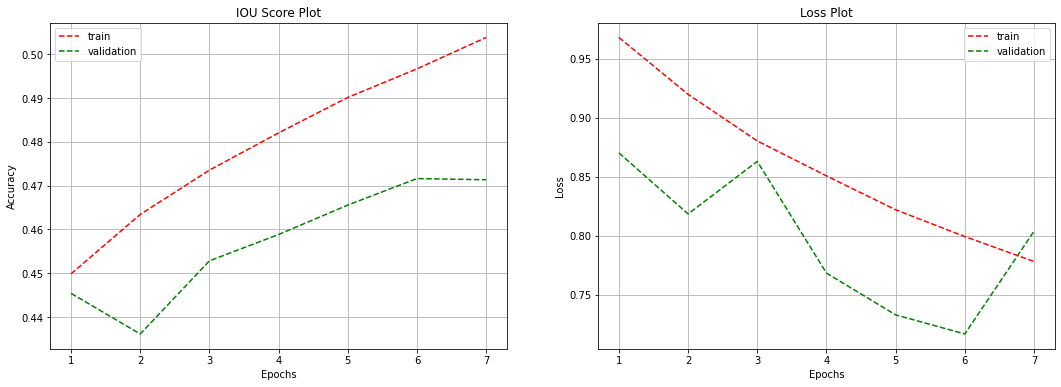

In [56]:
plot_model_performance(tracker=tracker, epochs=epochs)

In [57]:
model.load_weights(filepath='/content/best_model.h5')

In [58]:
def predict_test_data(x, model, n=20):
    x_ = x.head(n)
    h = IMG_HEIGHT
    w = IMG_WIDTH

    # paths of images
    images_fps   = x_['image'].to_list()
    # paths of masked images
    masks_fps    = x_['mask'].to_list()

    for oimg, mimg in zip(images_fps, masks_fps):
        # original image
        image = cv.imread(oimg, cv.IMREAD_UNCHANGED)
        image = cv.resize(image, (w, h), interpolation=cv.INTER_NEAREST)

        # masked image
        image_mask  = cv.imread(mimg, cv.IMREAD_UNCHANGED)
        image_mask = cv.resize(image_mask, (w, h), interpolation=cv.INTER_NEAREST)

        # prediction
        predicted_image  = model.predict(image[np.newaxis,:,:,:])
        predicted_mask = tf.argmax(predicted_image, axis=-1)

        plt.figure(figsize=(10, 6))
        plt.subplot(131)
        plt.imshow(image)
        plt.subplot(132)
        plt.imshow(image_mask, cmap=None)
        plt.subplot(133)
        plt.imshow(predicted_mask[0], cmap=None)
        plt.show()

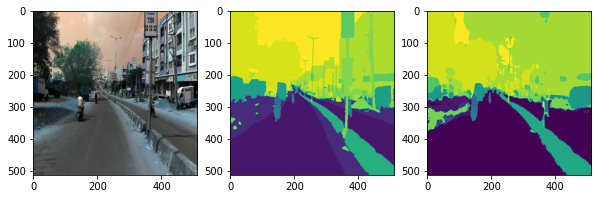

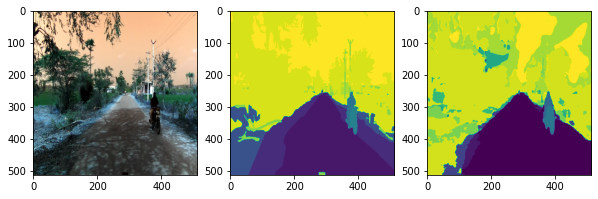

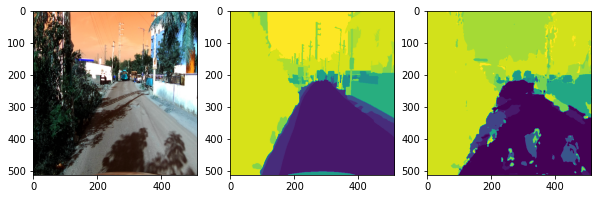

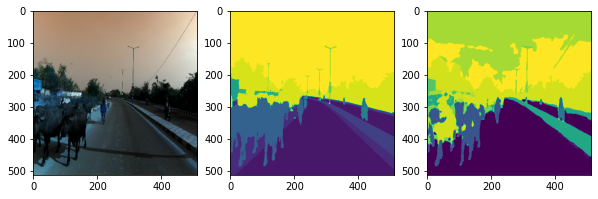

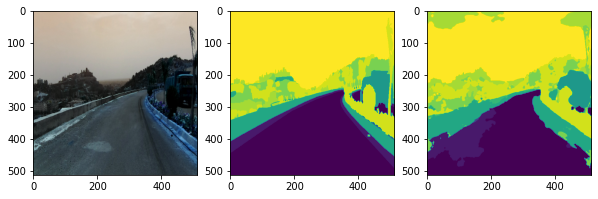

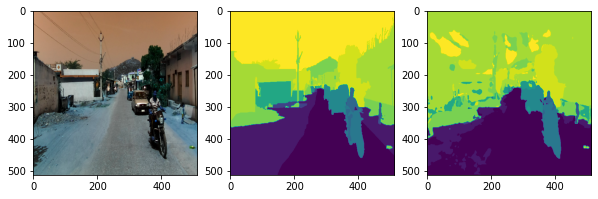

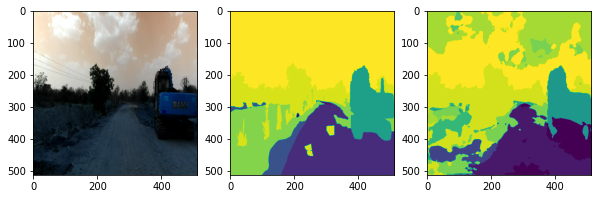

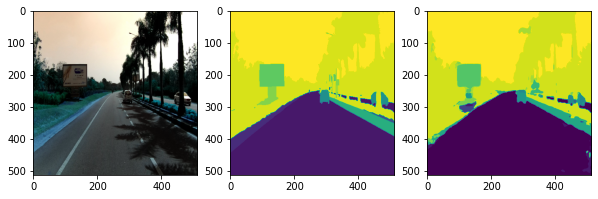

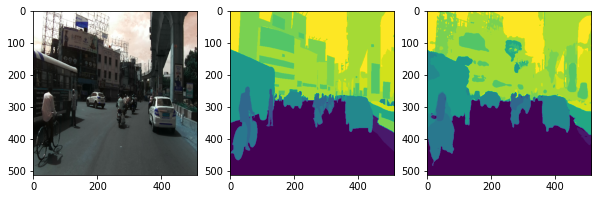

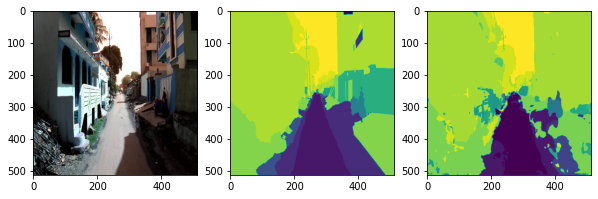

In [59]:
predict_test_data(x=X_test, model=model, n=10)

Task 3: Training CANet

In [60]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, 
    Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

* As a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder

    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    
    <font color="red">NOTE: These filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [63]:
class ConvolutionalBlock(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4, 4, 8], stride=2, name="conv block"):
        super().__init__(name=name)
        #####
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        #####

        # if we do not globalize these, then the params will be 0 in the summary
        self.b1 = BatchNormalization()
        self.b2 = BatchNormalization()
        self.b3 = BatchNormalization()
        self.bp = BatchNormalization() # parallel

        self.a1 = Activation('relu')
        self.a2 = Activation('relu')
        self.ap = Activation('relu') # parallel
        self.a3 = Activation('relu')

        self.conv_1 = Conv2D(filters=self.F1, 
                             kernel_size=(1, 1), 
                             strides=(self.stride, self.stride), 
                             padding='same')
        self.conv_2 = Conv2D(filters=self.F2, 
                             kernel_size=(self.kernel, self.kernel), 
                             strides=(1, 1), 
                             padding='same')
        self.conv_3 = Conv2D(filters=self.F3, 
                             kernel_size=(1, 1), 
                             strides=(1, 1), 
                             padding='same')
        self.conv_parallel = Conv2D(filters=self.F3, 
                                    kernel_size=(self.kernel, self.kernel), 
                                    strides=(self.stride, self.stride), 
                                    padding='same') # parallel
        
        self.add = Add()
    
    def call(self, X):
        # write the architecture that was mentioned above
        X_ = X

        conv_1 = self.conv_1(X)
        b1 = self.b1(conv_1)
        a1 = self.a1(b1)

        conv_2 = self.conv_2(a1)
        b2 = self.b2(conv_2)
        a2 = self.a2(b2)

        conv_3 = self.conv_3(a2)
        b3 = self.b3(conv_3)

        # parallel convolution with X
        conv_parallel = self.conv_parallel(X_)
        bp = self.bp(conv_parallel)
        ap = self.ap(bp)

        # element-wise sum
        ews = self.add([ap, b3])
        X = self.a3(ews)
        
        return X

In [64]:
class IdentityBlock(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4, 4, 8], name="identity block"):
        super().__init__(name=name)
        #####
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        #####

        # if we do not globalize these, then the params will be 0 in the summary
        self.b1 = BatchNormalization()
        self.b2 = BatchNormalization()
        self.b3 = BatchNormalization()

        self.a1 = Activation('relu')
        self.a2 = Activation('relu')
        self.a3 = Activation('relu')

        self.conv_1 = Conv2D(filters=self.F1, kernel_size=(1, 1), strides=(1, 1), padding='same')
        self.conv_2 = Conv2D(filters=self.F2, kernel_size=(self.kernel, self.kernel), strides=(1, 1), padding='same')
        self.conv_3 = Conv2D(filters=self.F3, kernel_size=(1, 1), strides=(1, 1), padding='same')

        self.add = Add()
    
    def call(self, X):
        # write the architecture that was mentioned above
        X_ = X

        conv_1 = self.conv_1(X)
        b1 = self.b1(conv_1)
        a1 = self.a1(b1)

        conv_2 = self.conv_2(a1)
        b2 = self.b2(conv_2)
        a2 = self.a2(b2)

        conv_3 = self.conv_3(a2)
        b3 = self.b3(conv_3)

        # parallel convolution
        conv_parallel = X_

        # element-wise sum
        ews = self.add([conv_parallel, b3])
        X = self.a3(ews)

        return X

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [65]:
class GlobalFlow(tf.keras.layers.Layer):
    def __init__(self, name="global_flow"):
        super().__init__(name=name)
        #####
        # self.input_dim = input_dim
        # self.output_dim = output_dim
        # self.channels = channels
        #####

        # if we do not globalize these, then the params will be 0 in the summary
        self.bn = BatchNormalization(axis=3)
        self.a = Activation('relu')

        self.global_avg = GlobalAveragePooling2D()
        self.conv = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same')
        self.ups = UpSampling2D(size=(64, 64), interpolation='bilinear')
        
    def call(self, X):
        # implement the global flow operation
        
        global_avg = self.global_avg(X)
        # expanding the dimensions from 2 to 4
        global_avg = tf.expand_dims(global_avg, 1)
        global_avg = tf.expand_dims(global_avg, 1)

        bn = self.bn(global_avg)
        a = self.a(bn)
        
        conv = self.conv(a)
        X = self.ups(conv)
        
        return X

In [66]:
class ContextFlow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)

        # if we do not globalize these, then the params will be 0 in the summary
        self.concat = Concatenate()
        self.avg_pool = AveragePooling2D(pool_size=(2, 2))
        self.ups = UpSampling2D(size=(2, 2), interpolation='bilinear')

        self.conv_1 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same')
        self.conv_2 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same')
        self.conv_3 = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same')
        self.conv_4 = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same')

        self.a1 = Activation('relu')
        self.a2 = Activation('sigmoid')

        self.mul = Multiply()
        self.add = Add()
    
    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        
        # implement the context flow as mentioned in the above cell
        concat = self.concat([INP, FLOW])
        avg_pool = self.avg_pool(concat)
        
        conv_1 = self.conv_1(avg_pool)
        conv_2 = self.conv_2(conv_1)
        
        conv_3 = self.conv_3(conv_2)
        a1 = self.a1(conv_3)

        conv_4 = self.conv_4(a1)
        a2 = self.a2(conv_4)

        mul = self.mul([conv_2, a2])
        add = self.add([conv_2, mul])
        X =self.ups(add)
        
        return X

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">

* The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [67]:
class FSM(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)

        # if we do not globalize these, then the params will be 0 in the summary
        self.bn = BatchNormalization()
        self.a = Activation('sigmoid')

        self.global_max = GlobalAveragePooling2D()
        self.ups = UpSampling2D(size=(2, 2), interpolation='bilinear')

        self.conv_1 = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same')
        self.conv_2 = Conv2D(filters=32, kernel_size=(1, 1), strides=(1, 1), padding='same')

        self.mul = Multiply()
        
    def call(self, X):
        # implement the FSM modules based on image in the above cells
        conv_1 = self.conv_1(X)
        
        global_max = self.global_max(conv_1)
        # expanding the dimensions from 2 to 4
        global_max = tf.expand_dims(global_max, 1)
        global_max = tf.expand_dims(global_max, 1)
        
        conv_2 = self.conv_2(global_max)
        bn = self.bn(conv_2)
        a = self.a(bn)
        
        mul = self.mul([conv_1, a])
        FSM_Conv_T = self.ups(mul)
        
        return FSM_Conv_T

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [68]:
class AGCN(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)

        # if we do not globalize these, then the params will be 0 in the summary
        self.conv_1 = Conv2D(filters=32, kernel_size=(7, 1), padding='same')
        self.conv_2 = Conv2D(filters=32, kernel_size=(1, 7), padding='same')
        self.conv_3 = Conv2D(filters=32, kernel_size=(1, 7), padding='same')
        self.conv_4 = Conv2D(filters=32, kernel_size=(7, 1), padding='same')
        self.conv_5 = Conv2D(filters=32, kernel_size=(3, 3), padding='same')

        self.add = Add()
        
    def call(self, X):
        # please implement the above mentioned architecture
        conv_1 = self.conv_1(X)
        conv_2 = self.conv_2(conv_1)

        conv_3 = self.conv_3(X)
        conv_4 = self.conv_4(conv_3)

        add_1 = self.add([conv_2, conv_4])

        conv_5 = self.conv_5(add_1)
        X = self.add([add_1, conv_5])
        
        return X

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

In [69]:
tf.keras.backend.clear_session()

X_input = Input(shape=(512, 512, 3))

# Stage 1
cb_0 = Conv2D(filters=64, kernel_size=(3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
cb_0 = BatchNormalization(axis=3, name='bn_conv1')(cb_0)
cb_0 = Activation('relu')(cb_0)
cb_0 = MaxPooling2D((2, 2), strides=(2, 2))(cb_0)

# C1
cb_1 = ConvolutionalBlock(kernel=3, filters=[4, 4, 8], stride=2, name='conv_block_1')(cb_0)
C1 = cb_1 # need this for decoder
# identity block repeating once
ib_1 = IdentityBlock(kernel=3, filters=[4, 4, 8], name='identity_block_1')(cb_1)

# C2
cb_2 = ConvolutionalBlock(kernel=3, filters=[8, 8, 16], stride=2, name='conv_block_2')(ib_1)
# identity block repeating twice
ib_2_a = IdentityBlock(kernel=3, filters=[8, 8, 16], name='identity_block_2a')(cb_2)
ib_2_b = IdentityBlock(kernel=3, filters=[8, 8, 16], name='identity_block_2b')(ib_2_a)

# C3
cb_3 = ConvolutionalBlock(kernel=3, filters=[16, 16, 32], stride=1, name='conv_block_3')(ib_2_a)
# identity block repeating thrice
ib_3_a = IdentityBlock(kernel=3, filters=[16, 16, 32], name='identity_block_3a')(cb_3)
ib_3_b = IdentityBlock(kernel=3, filters=[16, 16, 32], name='identity_block_3b')(ib_3_a)
ib_3_c = IdentityBlock(kernel=3, filters=[16, 16, 32], name='identity_block_3c')(ib_3_b)

# C4
cb_4 = ConvolutionalBlock(kernel=3, filters=[32, 32, 64], stride=1, name='conv_block_4')(ib_3_c)
# identity block repeating four time
ib_4_a = IdentityBlock(kernel=3, filters=[32, 32, 64], name='identity_block_4a')(cb_4)
ib_4_b = IdentityBlock(kernel=3, filters=[32, 32, 64], name='identity_block_4b')(ib_4_a)
ib_4_c = IdentityBlock(kernel=3, filters=[32, 32, 64], name='identity_block_4c')(ib_4_b)
# this becomes the input for CAM
ib_4_d = IdentityBlock(kernel=3, filters=[32, 32, 64], name='identity_block_4d')(ib_4_c)

X = GlobalFlow(name='global_flow')(ib_4_d)
cf_1 = ContextFlow(name='context_flow_1')([ib_4_d, X])
cf_2 = ContextFlow(name='context_flow_2')([ib_4_d, X])
cf_3 = ContextFlow(name='context_flow_3')([ib_4_d, X])

sum_all = Add()([X, cf_1, cf_2, cf_3])
X_FSM = FSM(name='fsm_layer')(sum_all)
X_AGCN = AGCN(name='agcn_layer')(C1)
concat = Concatenate()([X_FSM, X_AGCN])

# 21 classes
conv_final = Conv2D(filters=21, kernel_size=(1, 1), strides=(1, 1), padding='same')(concat)
up_4  = UpSampling2D(size=(4, 4), interpolation='bilinear')(conv_final)

output = Activation('softmax')(up_4)

model = Model(inputs=X_input, outputs=output)

* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [70]:
# write the complete architecutre
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 512, 512, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 64) 0           bn_conv1[0][0]                   
______________________________________________________________________________________________

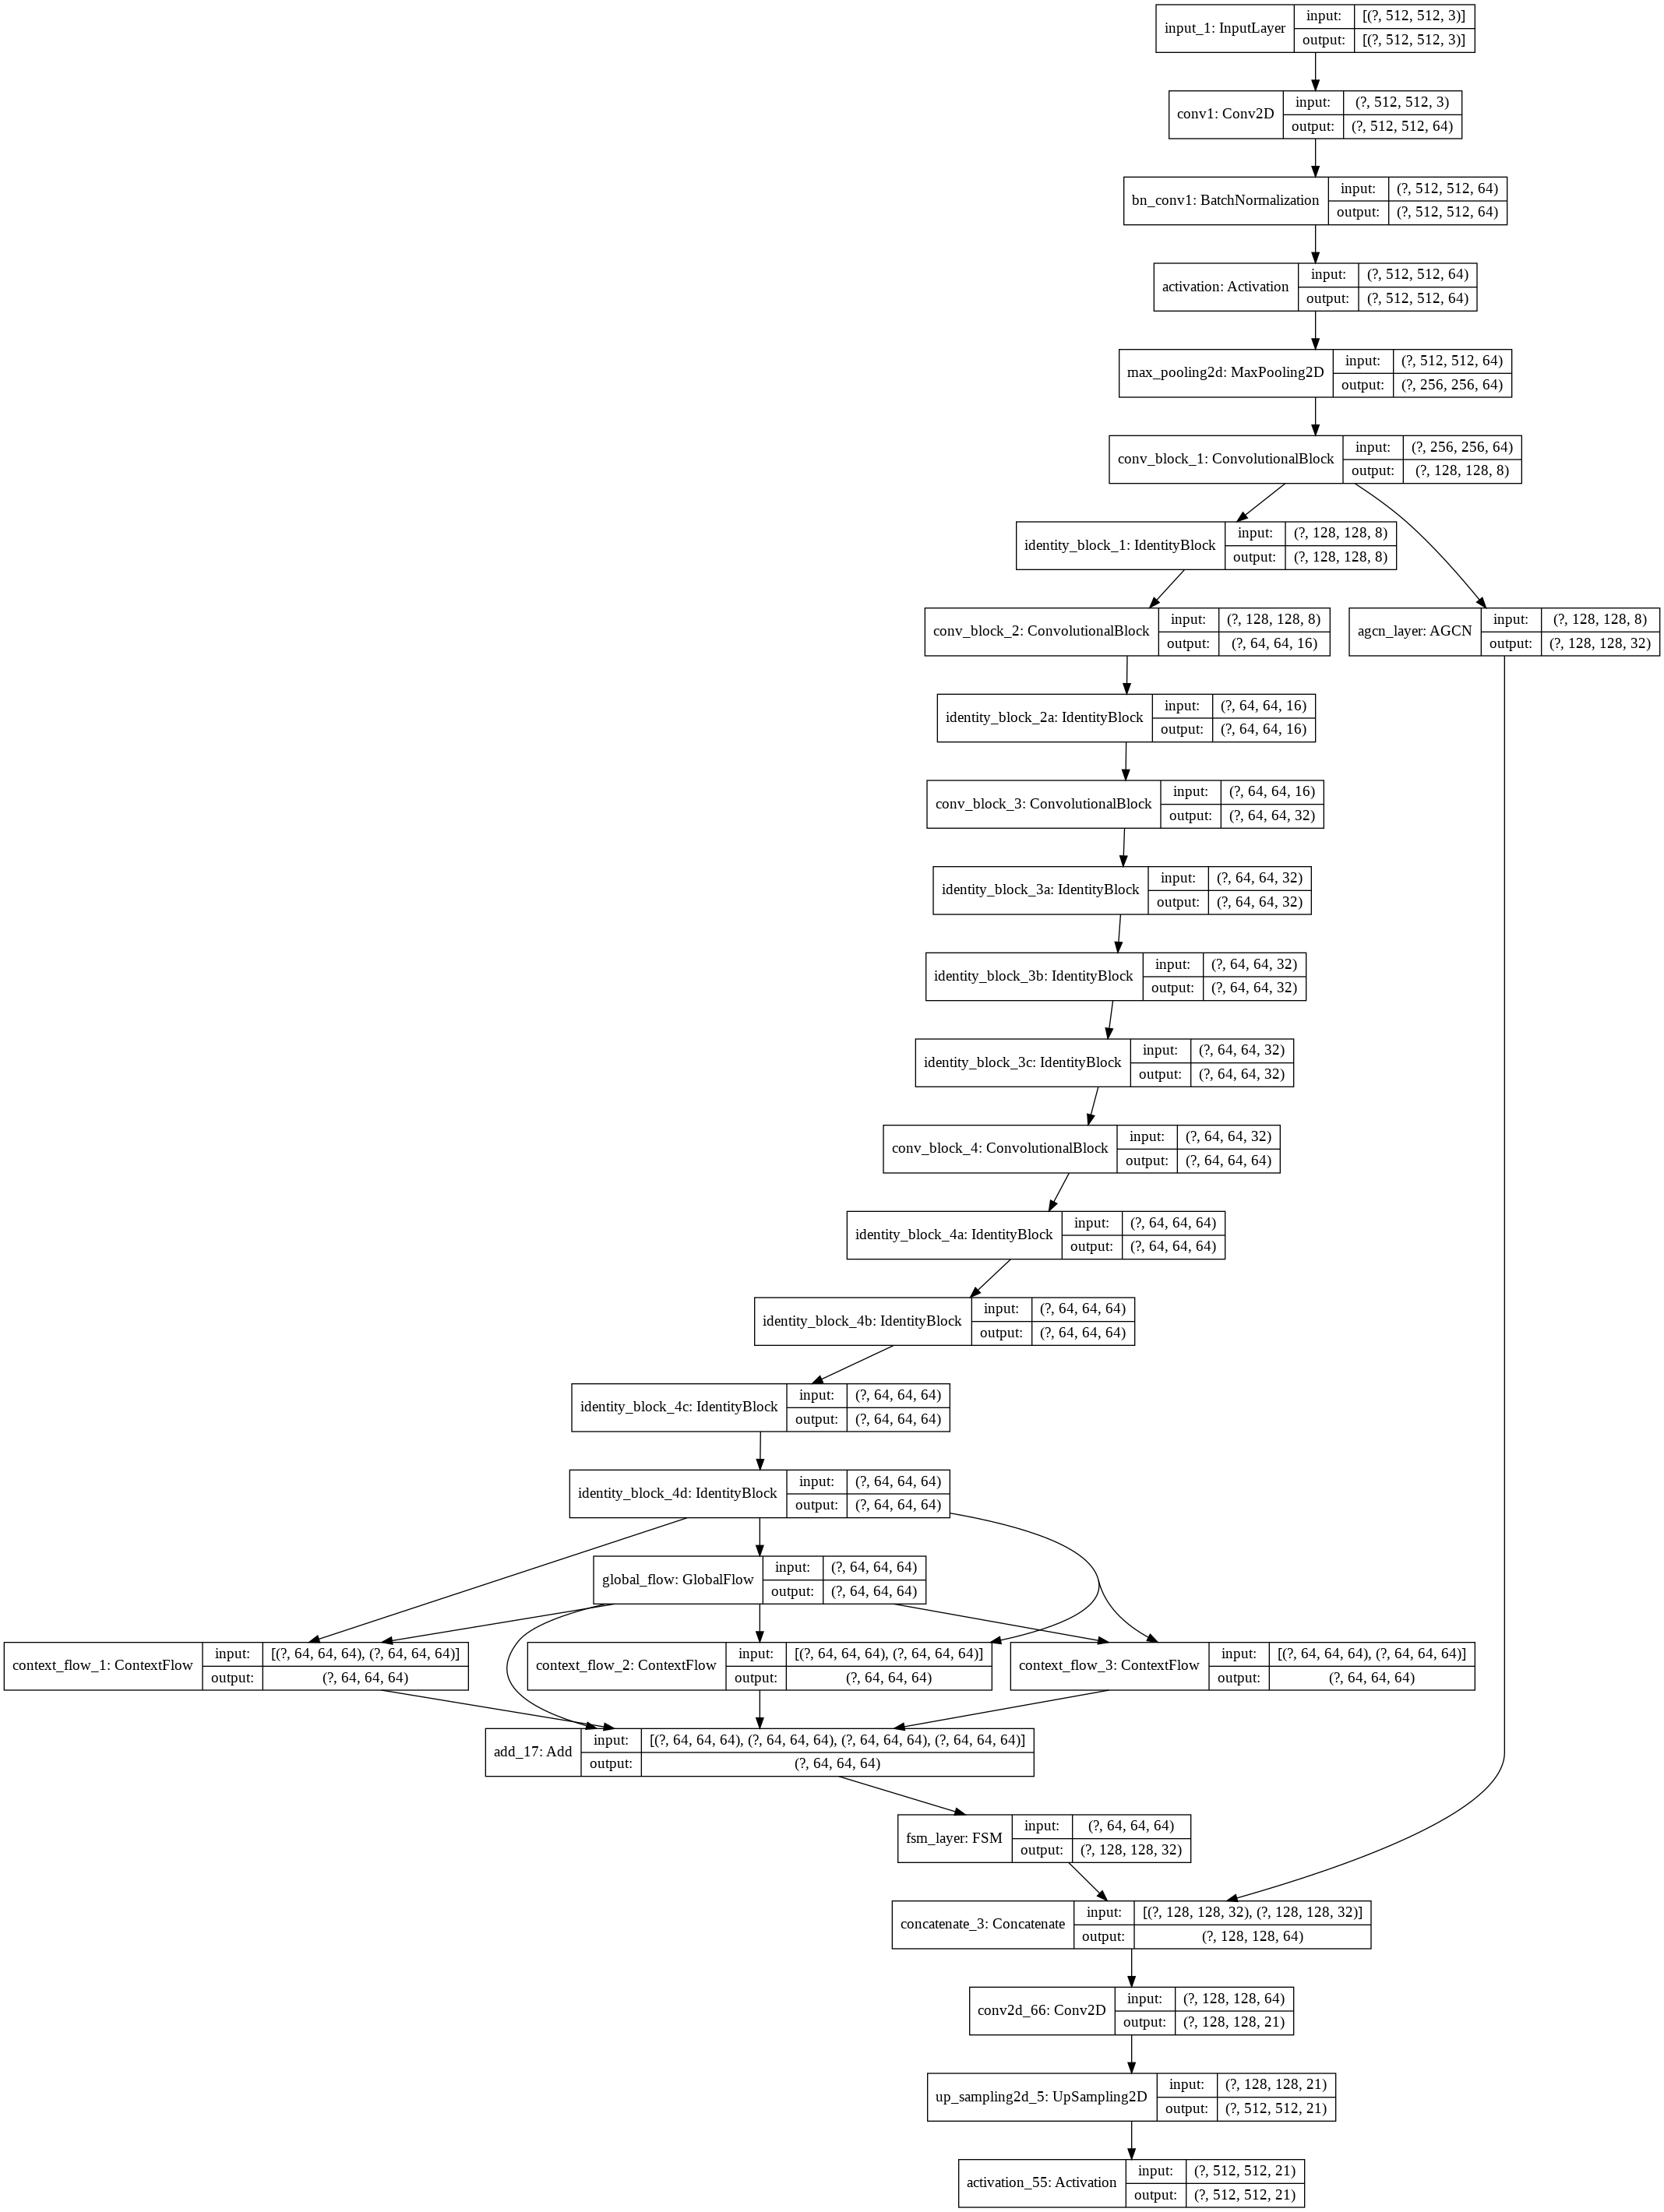

In [71]:
tf.keras.utils.plot_model(
    model, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [72]:
optimizer = tf.keras.optimizers.Adam(1e-4)

# cce_dice_loss = categorical_crossentropy + dice_loss
focal_loss = sm.losses.cce_dice_loss

# callbacks
model_save_callback = ModelCheckpoint(filepath='./best_model_canet.h5', 
                                      save_weights_only=True, 
                                      save_best_only=True, 
                                      mode='max', 
                                      monitor='val_iou_score')
callbacks = [model_save_callback]

model.compile(optimizer=optimizer, loss=focal_loss, metrics=[iou_score])

In [73]:
epochs = 5
tracker = model.fit(x=train_dataloader,
                    steps_per_epoch=len(train_dataloader),
                    epochs=epochs,
                    validation_data=test_dataloader,
                    callbacks=callbacks)

Epoch 1/5
3567/3567 [==============================] - 1832s 514ms/step - loss: 1.7663 - iou_score: 0.2756 - val_loss: 4.5533 - val_iou_score: 0.1930
Epoch 2/5
3567/3567 [==============================] - 1856s 520ms/step - loss: 1.4761 - iou_score: 0.3482 - val_loss: 4.3806 - val_iou_score: 0.2258
Epoch 3/5
3567/3567 [==============================] - 1809s 507ms/step - loss: 1.3910 - iou_score: 0.3602 - val_loss: 4.7540 - val_iou_score: 0.2497
Epoch 4/5
3567/3567 [==============================] - 1785s 500ms/step - loss: 1.3284 - iou_score: 0.3691 - val_loss: 4.4102 - val_iou_score: 0.1839
Epoch 5/5
3567/3567 [==============================] - 1757s 493ms/step - loss: 1.2847 - iou_score: 0.3760 - val_loss: 3.7101 - val_iou_score: 0.2399


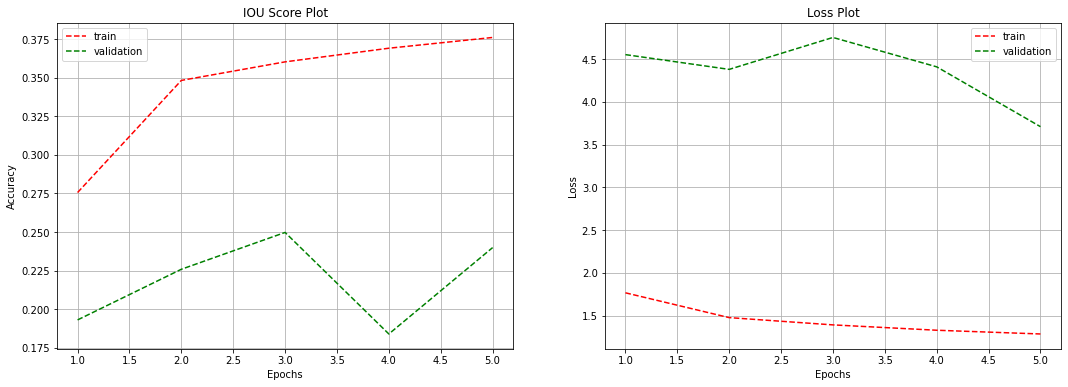

In [74]:
plot_model_performance(tracker=tracker, epochs=epochs)

In [75]:
model.load_weights(filepath='/content/best_model_canet.h5')

In [76]:
def predict_test_data(x, model, n=20):
    x_ = x.head(n)
    h = IMG_HEIGHT
    w = IMG_WIDTH

    # paths of images
    images_fps   = x_['image'].to_list()
    # paths of masked images
    masks_fps    = x_['mask'].to_list()

    for oimg, mimg in zip(images_fps, masks_fps):
        # original image
        image = cv.imread(oimg, cv.IMREAD_UNCHANGED)
        image = cv.resize(image, (w, h), interpolation=cv.INTER_NEAREST)

        # masked image
        image_mask  = cv.imread(mimg, cv.IMREAD_UNCHANGED)
        image_mask = cv.resize(image_mask, (w, h), interpolation=cv.INTER_NEAREST)

        # prediction
        predicted_image  = model.predict(image[np.newaxis,:,:,:])
        predicted_mask = tf.argmax(predicted_image, axis=-1)

        plt.figure(figsize=(10, 6))
        plt.subplot(131)
        plt.imshow(image)
        plt.subplot(132)
        plt.imshow(image_mask, cmap=None)
        plt.subplot(133)
        plt.imshow(predicted_mask[0], cmap=None)
        plt.show()

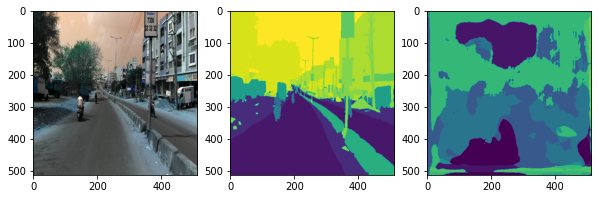

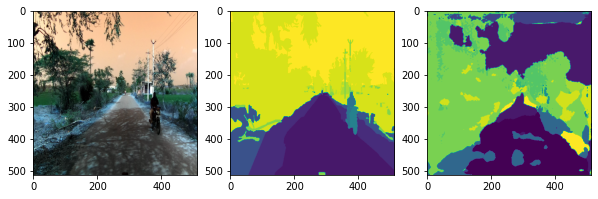

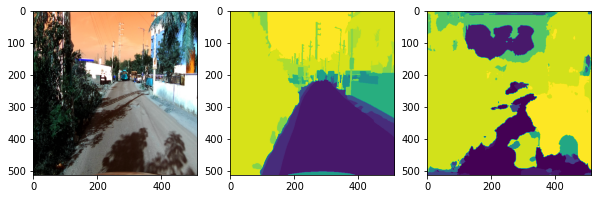

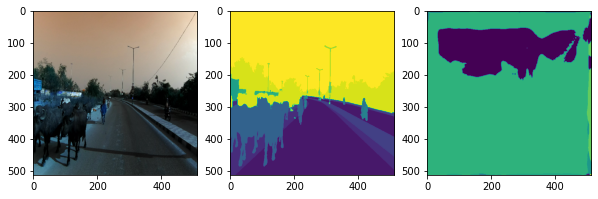

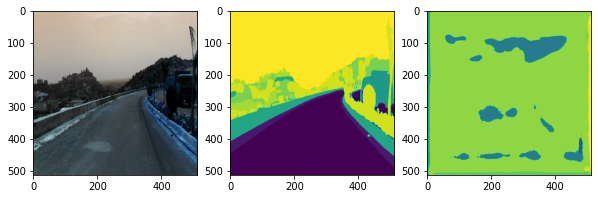

In [77]:
predict_test_data(x=X_test, model=model, n=5)

Conclusion

1. This assignment implements segmentation on Indian Traffic data.

2. Image size that is considered for this is (512, 512, 3) (as the team suggested).

3. Task 1 is to generate the masks for the whole dataset. This is data preprocessing task.

4. Task 2 is to implement UNet model for the segmentation. I used `resnet34` as a backbone model. I got the IOU score about 0.5

5. Task 3 is to implement CaNet model. I see the UNet model has obtained good IOU score compared to CaNet model.

---

Usefull tips:

* use "interpolation=cv2.INTER_NEAREST" when you are resizing the image, so that it won't mess with the number of classes
* keep the images in the square shape like $256*256$ or $512*512$
* Carefull when you are converting the (W, H) output image into (W, H, Classes)
* Even for the canet, use the segmentation model's losses and the metrics
* The goal of this assignment is make you familier in with computer vision problems, image preprocessing, building complex architectures and implementing research papers, so that in future you will be very confident in industry
* you can use the tensorboard logss to see how is yours model's training happening
* use callbacks that you have implemented in previous assignments

Things to keep in mind

* You need to train  above built model and plot the train and test losses.
* Make sure there is no overfitting, you are free play with the identity blocks in C1, C2, C3, C4
* before we apply the final sigmoid activation, you can add more conv layers or BN or dropouts etc
* you are free to use any other optimizer or learning rate or weights init or regularizations